# Отток клиентов

Из «N-Банка» каждый месяц стало уходить некоторое кол-во клиентов. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

`Цель:` Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

`Задача:`Построить модель прогнозирование ухода клиента.

`Метрика:` *F1*

`Дополнительна метрика:` *AUC-ROC*
 
`Условие принятия:` метрика 0.59


`Источник данных:` [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)



`Описание данных`
Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет

`Признаки:`
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата


`Целевой признак:`
- Exited — факт ухода клиента

`План:`
- Подготовка данных
- Исследование данных (включая баланс классов)
- Обучение моделей без учета дисбаланса
- Обработка дисбаланса классов
- Обучение моделей после обработки данных
- Тестирование

### Подключение библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import PolynomialFeatures
import warnings


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score, recall_score



from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 

In [2]:
warnings.filterwarnings('ignore')

### Загрузка данных и основная информация

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Уберем лишние признаки.

In [5]:
df = df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [7]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### Вывод: 

- Удалены лишние признаки.

- Типы данных в порядке, пропуски присутствуют в столбце Tenure.

- Из основной статистики: отрицательных (аномальных для данных признаков) значений нет. 

- Похоже присутствуют выбросы по признаку Balance, так как 75% данных ниже 130000, а максимальное значение 250000. 

- Миинимальное значение возраста адекватное 18 лет. Возможно выброс по верхнему значению.

### Проверка данных на пропуски, дубликаты и аномалии

In [8]:
df.isna().sum() # подсчёт пропусков

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [9]:
df.isna().mean() # Доля пропусков

CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

Пропуски есть только в признаке 'Tenure' — сколько лет человек является клиентом банка, меньше 10% , при небольшом кол-ве можно удалить.

In [10]:
#df['Tenure'].median()

df = df.fillna(df['Tenure'].median())

In [11]:
#df = df.dropna()
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
df.duplicated().sum() # подсчет дубликатов

0

Явных дубликатов нет.

Построим боксплоты для количественных признаков, чтобы отследить выбросы в данных.

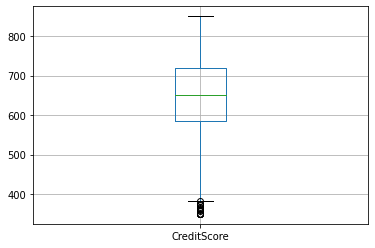

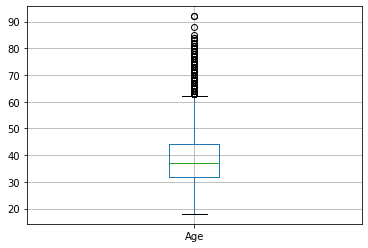

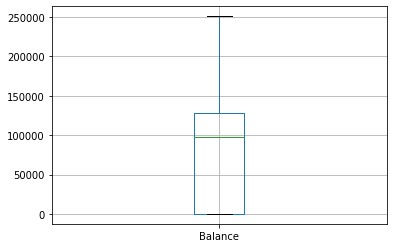

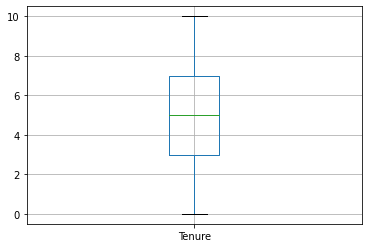

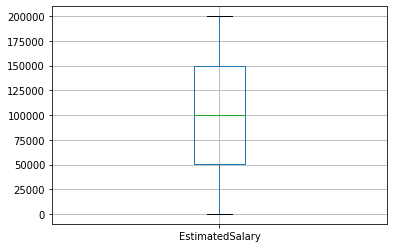

In [13]:
par_list = ['CreditScore','Age','Balance','Tenure','EstimatedSalary']


for par in par_list:
    df.boxplot(column =par)
    plt.show()

Есть выбросы в двух признаках: 'Age', 'CreditScore' 

In [14]:
df['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

In [15]:
sum(df.loc[df['Age'] > 65,'Exited'] == 1)/sum(df['Exited'] == 1) 
#доля людей старше 65 среди ушедших клиентов

0.01718213058419244

In [16]:
df['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

In [17]:
sum(df.loc[df['CreditScore'] < 401,'Exited'] == 1)/sum(df['Exited'] == 1) 
# доля людей с рейтингом меньше 400 среди ушедших клиентов

0.009327442317133039

Возьмем к исследованию только данные входящие в доверительный интервал (99%)

In [18]:
par_list = ['Age','CreditScore']


for par in par_list:    
    mean, sigma = np.mean(df[par]), np.std(df[par])

    conf_int = stats.norm.interval(0.99, loc=mean, scale=sigma) 
    print(conf_int)

    df = df.loc[df[par] >= 0 ] # в наших данных не должно быть отрицательных значений, поэтому поставила >= 0
    df = df.loc[df[par] < conf_int[1]]

(11.908351585479647, 65.93524841452034)
(401.26869609563335, 899.050531513241)


Посмотрим корреляцию между количественными признаками:

In [19]:
par = ['CreditScore','Age','Balance','Tenure','EstimatedSalary']


corr_df=df[par]  
cor= corr_df.corr(method='pearson')
print(cor)

                 CreditScore       Age   Balance    Tenure  EstimatedSalary
CreditScore         1.000000 -0.019050  0.006002 -0.000078        -0.000669
Age                -0.019050  1.000000  0.042245 -0.017375        -0.008136
Balance             0.006002  0.042245  1.000000 -0.008812         0.011371
Tenure             -0.000078 -0.017375 -0.008812  1.000000         0.011059
EstimatedSalary    -0.000669 -0.008136  0.011371  0.011059         1.000000


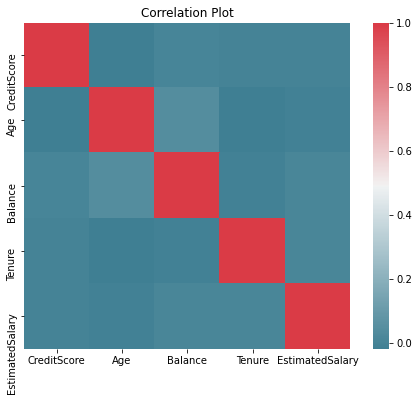

In [20]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Кореляция отсутствует.

### Подготовка признаков и разделение данных

В особенности для линейных моделей необходимо масштабирование и кодирование категориальных признаков.

In [21]:
df_ohe =  pd.get_dummies(df, drop_first=True) # кодирование категориальных признаков

In [22]:
df_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


In [23]:
target = df_ohe['Exited']
features = df_ohe.drop('Exited',axis=1)

#features_train, features_valid,target_train, target_valid = train_test_split(features,target,
 #                                                                            test_size = 0.25, 
  #                                                                           random_state=12345)

In [24]:
print(df_ohe.loc[df['Exited'] == 0].shape, df_ohe.loc[df['Exited'] == 1].shape) # изначальное распределение меток ~ 3:1

features_train, features_test, target_train, target_test = train_test_split(
   features, target, test_size=0.4, random_state=12345,stratify=target)

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")
print()


features_test, features_valid, target_test, target_valid = train_test_split(
   features_test, target_test, test_size=0.5, random_state=12345, stratify= target_test)


print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")

(7734, 12) (2002, 12)
Количество строк в target_train по классам: [4640 1201]
Количество строк в target_test по классам: [3094  801]

Количество строк в target_train по классам: [4640 1201]
Количество строк в target_valid по классам: [1547  401]


In [25]:
# масштабирование численных признаков

numeric = ['CreditScore', 'Age', 'Balance', 'Tenure','NumOfProducts','EstimatedSalary'] 

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

## Исследование задачи

### Изучим баланс классов

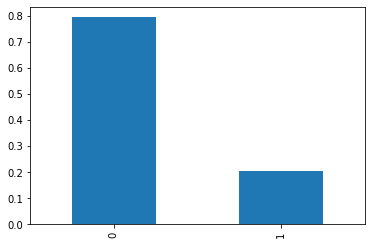

In [26]:
class_frequency = target.value_counts(normalize=True)

class_frequency.plot(kind='bar')
plt.show()

In [27]:
class_frequency

0    0.794371
1    0.205629
Name: Exited, dtype: float64

Сильный дисбаланс классов

### Изучим модели без учёта дисбаланса

#### Дерево классификации

In [28]:
best_model_tree_classifier = None
best_result = 0
for depth in range(1, 4):
    model = DecisionTreeClassifier(random_state=12345, max_depth= depth) 
    model.fit(features_train,target_train) 
    predictions = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_model_tree_classifier = model
        best_result = result
print("Accuracy лучшей модели на обучающей выборке:", accuracy_score(target_train, best_model_tree_classifier.predict(features_train)))
print("Accuracy лучшей модели на валидационной выборке:", best_result)
print(best_model_tree_classifier)

Accuracy лучшей модели на обучающей выборке: 0.847457627118644
Accuracy лучшей модели на валидационной выборке: 0.8434291581108829
DecisionTreeClassifier(max_depth=3, random_state=12345)


In [29]:
predicted_valid = best_model_tree_classifier.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5211930926216639


#### Случайный лес

In [30]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [10,100],
    'max_depth' : [2,3,4,5,6],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(features_train, target_train)


print(CV_rfc.best_params_)

{'max_depth': 6, 'n_estimators': 100}


In [57]:
best_model_forest_classifier = RandomForestClassifier(random_state=42,  n_estimators= 100, max_depth=6)

In [58]:
best_model_forest_classifier.fit(features_train, target_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [59]:
print("Accuracy лучшей модели на обучающей выборке:",accuracy_score(target_train, 
                                                                    best_model_forest_classifier.
                                                                    predict(features_train)))
print("Accuracy лучшей модели на валидационной выборке:", best_result)

Accuracy лучшей модели на обучающей выборке: 0.819980643079901
Accuracy лучшей модели на валидационной выборке: 0.8208418891170431


In [60]:
predicted_valid = best_model_forest_classifier.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5218617771509169


#### Логистическая регрессия

In [35]:
best_model_logistic_reg = None
best_result = 0

for regularization_s in [1,10,100]:
    for solver in ['lbfgs', 'liblinear']:
        model = LogisticRegression(random_state = 12345,solver=solver, max_iter=1000, C = regularization_s)
        model.fit(features_train,target_train)
        model.predict(features_valid)
        result = model.score(features_valid,target_valid)
        #print(model,result)
            
        if result > best_result:
            best_model_logistic_reg =  model 
            best_result = result 
            
            
print('Лучшая конфигурация',best_model_logistic_reg,best_result)   



Лучшая конфигурация LogisticRegression(C=1, max_iter=1000, random_state=12345, solver='liblinear') 0.8208418891170431


In [36]:
predicted_valid = best_model_logistic_reg.predict(features_valid)

print(best_model_logistic_reg.score(features_train, target_train))
print("F1:", f1_score(target_valid, predicted_valid))

0.8216058894024996
F1: 0.39931153184165236


## Борьба с дисбалансом

### Взвешивание классов

Возьмем лучшие подобранные конфигурации моделей и добавим параметр class_weight='balanced'

In [38]:
# дерево

model_tree = DecisionTreeClassifier(max_depth=3, random_state=12345,class_weight='balanced')
model_tree.fit(features_train,target_train)
predicted_valid =model_tree.predict(features_valid)
model_tree.score(features_valid,target_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5429769392033543


In [61]:
# лес

model_forest = RandomForestClassifier(max_depth=6, n_estimators=100,random_state=12345,
                                      class_weight='balanced')
model_forest.fit(features_train,target_train)
predicted_valid = model_forest.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6276595744680852


In [40]:
# лин. регрессия

model_log_reg = LogisticRegression(C=1, max_iter=1000, random_state=12345,class_weight='balanced')
model_log_reg.fit(features_train,target_train)
predicted_valid = model_log_reg.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5189873417721519


### Борьба с дисбалансом с помощью увеличение выборки

In [62]:
# Функция для создания копий объектов редкого класса внутри данных

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled


In [63]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [65]:
model_tree = DecisionTreeClassifier(max_depth=3, random_state=12345,class_weight='balanced')
model_tree.fit(features_upsampled, target_upsampled)
predicted_valid =model_tree.predict(features_valid)

print("Tree F1:", f1_score(target_valid, predicted_valid))

model_forest = RandomForestClassifier(max_depth=6, n_estimators=100,random_state=12345,
                                      class_weight='balanced')
model_forest.fit(features_upsampled, target_upsampled)
predicted_valid = model_forest.predict(features_valid)
print("Forrest F1:", f1_score(target_valid, predicted_valid))


model_log_reg = LogisticRegression(C=1, max_iter=1000, random_state=12345,class_weight='balanced')
model_log_reg.fit(features_upsampled, target_upsampled)
predicted_valid = model_log_reg.predict(features_valid)
print("L. Reg. F1:", f1_score(target_valid, predicted_valid))


Tree F1: 0.5429769392033543
Forrest F1: 0.6180257510729613
L. Reg. F1: 0.519927536231884


###  Борьба с дисбалансом с помощью уменьшение выборки

In [44]:
# Функция для удаления объектов популярного класса внутри данных

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [45]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

### Результаты моделей после балансировки

In [66]:
model_tree = DecisionTreeClassifier(max_depth=3, random_state=12345,class_weight='balanced')
model_tree.fit(features_downsampled, target_downsampled)
predicted_valid =model_tree.predict(features_valid)

print("Tree F1:", f1_score(target_valid, predicted_valid))

model_forest = RandomForestClassifier(max_depth=6, n_estimators=100,random_state=12345,
                                      class_weight='balanced')
model_forest.fit(features_downsampled, target_downsampled)
predicted_valid = model_forest.predict(features_valid)
print("Forrest F1:", f1_score(target_valid, predicted_valid))


model_log_reg = LogisticRegression(C=1, max_iter=1000, random_state=12345,class_weight='balanced')
model_log_reg.fit(features_downsampled, target_downsampled)
predicted_valid = model_log_reg.predict(features_valid)
print("L. Reg. F1:", f1_score(target_valid, predicted_valid))

Tree F1: 0.5352743561030235
Forrest F1: 0.5642795513373597
L. Reg. F1: 0.5082680591818972


In [67]:
#features_train, target_train = features_downsampled, target_downsampled

features_train, target_train = features_upsampled, target_upsampled


### Уменьшение порога

Любая наша модель выдаёт вероятности на выходе. А потом, с помощью порога переводим в 1 и 0. Внутри predict-а зашит порог 0.5 по умолчанию. Мы можем подобрать иной порог для маркировки 1 и 0.

In [48]:
probabilities_tree = model_tree.predict_proba(features_valid)
probabilities_forest = model_forest.predict_proba(features_valid)
probabilities_log_reg = model_log_reg.predict_proba(features_valid)

In [49]:
probabilities_one_valid_tree = probabilities_tree[:,1]
probabilities_one_valid_forest = probabilities_forest[:,1]
probabilities_one_valid_log_reg = probabilities_log_reg[:,1]

In [50]:
# Подбор порога

def threshold(probabilities_one_valid, a,b,c):
    predicted_valid = 0
    precision = 0
    recall = 0
    for threshold in np.arange(a,b,c):
        predicted_valid = probabilities_one_valid > threshold 
        precision = precision_score(target_valid, predicted_valid) 
        recall = recall_score(target_valid, predicted_valid) 
        
        print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
    
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < напишите код здесь >

    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("ROC-кривая")
    return roc_auc_score(target_valid,probabilities_one_valid)

Порог = 0.00 | Точность = 0.206, Полнота = 1.000
Порог = 0.05 | Точность = 0.206, Полнота = 1.000
Порог = 0.10 | Точность = 0.206, Полнота = 1.000
Порог = 0.15 | Точность = 0.296, Полнота = 0.943
Порог = 0.20 | Точность = 0.296, Полнота = 0.943
Порог = 0.25 | Точность = 0.296, Полнота = 0.943
Порог = 0.30 | Точность = 0.296, Полнота = 0.943
Порог = 0.35 | Точность = 0.296, Полнота = 0.943
Порог = 0.40 | Точность = 0.296, Полнота = 0.943
Порог = 0.45 | Точность = 0.486, Полнота = 0.596
Порог = 0.50 | Точность = 0.486, Полнота = 0.596
Порог = 0.55 | Точность = 0.486, Полнота = 0.596
Порог = 0.60 | Точность = 0.486, Полнота = 0.596
Порог = 0.65 | Точность = 0.493, Полнота = 0.594
Порог = 0.70 | Точность = 0.493, Полнота = 0.594
Порог = 0.75 | Точность = 0.768, Полнота = 0.297


0.7990100701704048

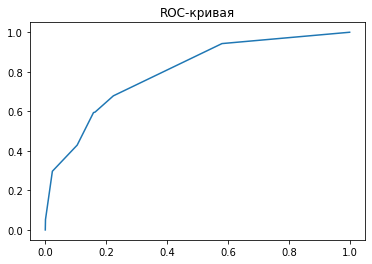

In [51]:
threshold(probabilities_one_valid_tree,0,  0.8, 0.05)

Порог = 0.00 | Точность = 0.206, Полнота = 1.000
Порог = 0.05 | Точность = 0.206, Полнота = 1.000
Порог = 0.10 | Точность = 0.206, Полнота = 1.000
Порог = 0.15 | Точность = 0.219, Полнота = 1.000
Порог = 0.20 | Точность = 0.231, Полнота = 0.993
Порог = 0.25 | Точность = 0.259, Полнота = 0.970
Порог = 0.30 | Точность = 0.298, Полнота = 0.953
Порог = 0.35 | Точность = 0.322, Полнота = 0.913
Порог = 0.40 | Точность = 0.348, Полнота = 0.870
Порог = 0.45 | Точность = 0.391, Полнота = 0.833
Порог = 0.50 | Точность = 0.452, Полнота = 0.793
Порог = 0.55 | Точность = 0.511, Полнота = 0.723
Порог = 0.60 | Точность = 0.581, Полнота = 0.663
Порог = 0.65 | Точность = 0.628, Полнота = 0.581
Порог = 0.70 | Точность = 0.694, Полнота = 0.481
Порог = 0.75 | Точность = 0.753, Полнота = 0.404


0.8496784863955174

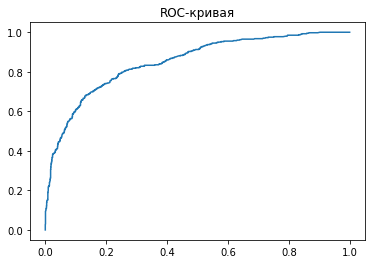

In [52]:
threshold(probabilities_one_valid_forest,0,  0.8, 0.05)

Порог = 0.00 | Точность = 0.206, Полнота = 1.000
Порог = 0.05 | Точность = 0.207, Полнота = 0.998
Порог = 0.10 | Точность = 0.217, Полнота = 0.995
Порог = 0.15 | Точность = 0.231, Полнота = 0.980
Порог = 0.20 | Точность = 0.251, Полнота = 0.965
Порог = 0.25 | Точность = 0.269, Полнота = 0.930
Порог = 0.30 | Точность = 0.292, Полнота = 0.903
Порог = 0.35 | Точность = 0.311, Полнота = 0.865
Порог = 0.40 | Точность = 0.344, Полнота = 0.835
Порог = 0.45 | Точность = 0.366, Полнота = 0.786
Порог = 0.50 | Точность = 0.390, Полнота = 0.728
Порог = 0.55 | Точность = 0.417, Полнота = 0.671
Порог = 0.60 | Точность = 0.465, Полнота = 0.618
Порог = 0.65 | Точность = 0.497, Полнота = 0.534
Порог = 0.70 | Точность = 0.546, Полнота = 0.471
Порог = 0.75 | Точность = 0.581, Полнота = 0.401


0.792703116159182

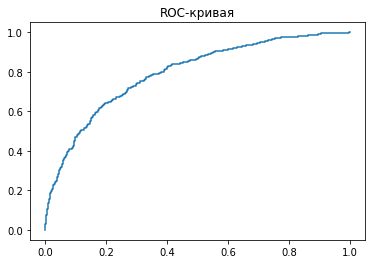

In [53]:
threshold(probabilities_one_valid_log_reg,0,  0.8, 0.05)

## Тестирование модели

In [54]:
## Обобщим обучающую выборку

In [68]:
features_train = pd.concat([features_train, features_valid], axis=0)


target_train = pd.concat([target_train, target_valid], axis=0)


In [28]:
features_test[numeric] = scaler.transform(features_test[numeric])

In [29]:
model_tree = DecisionTreeClassifier(max_depth=3, random_state=12345,class_weight='balanced')
model_tree.fit(features_train, target_train)
predicted_valid =model_tree.predict(features_valid)
predicted_test =model_tree.predict(features_test)


print("Tree F1 valid:", f1_score(target_valid, predicted_valid))
print("Tree F1 test:", f1_score(target_test, predicted_test))
print('Recall',recall_score(target_valid,predicted_valid),
      'Precision', precision_score(target_valid,predicted_valid))
print()


model_forest = RandomForestClassifier(max_depth=6, n_estimators=100,random_state=12345,class_weight='balanced')
model_forest.fit(features_train, target_train)
predicted_valid =model_forest.predict(features_valid)
predicted_test = model_forest.predict(features_test)

print("Forest F1 valid:", f1_score(target_valid, predicted_valid))
print("Forrest F1 test:", f1_score(target_test, predicted_test))
print('Recall',recall_score(target_valid,predicted_valid),
      'Precision', precision_score(target_valid,predicted_valid))
print()
print()


model_log_reg = LogisticRegression(C=1, max_iter=1000, random_state=12345,class_weight='balanced')
model_log_reg.fit(features_train, target_train)
predicted_valid =model_log_reg.predict(features_valid)
predicted_test = model_log_reg.predict(features_test)


print("L. Reg. F1 valid:", f1_score(target_valid, predicted_valid))
print("L. Reg. F1 test:", f1_score(target_test, predicted_test))
print('Recall',recall_score(target_valid,predicted_valid),
      'Precision', precision_score(target_valid,predicted_valid))
print()
print()


Tree F1 valid: 0.5429769392033543
Tree F1 test: 0.5294748124330118
Recall 0.6458852867830424 Precision 0.46835443037974683

Forest F1 valid: 0.6258064516129032
Forrest F1 test: 0.5945945945945946
Recall 0.7256857855361596 Precision 0.5500945179584121


L. Reg. F1 valid: 0.5189873417721519
L. Reg. F1 test: 0.5162488393686165
Recall 0.71571072319202 Precision 0.40709219858156026




## Вывод

В результате работы было сделано следующее:

- Проведена предобработка данных, обработка пропусков и дубликатов
- Исследован баланс классов
- Обучены три модели без учета дисбаланса
- Проведена обработка дисбаланса классов тремя различными способами
- Обучены модели после обработки данных
- Проведено тестирование

Лучший результат показала модель случайного леса с параметрами: max_depth=6, n_estimators=100,random_state=12345,class_weight='balanced'

На валидационной выборке лес дает приемлемый результат f1, но точность достаточно низкая, значит модель часто дает ложно-положительый ответ.